## Imports/Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.3 MB/s eta 0:00:00


In [3]:
# Some imports that you might need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import nltk
import os
import re
import seaborn as sns
from tqdm import tqdm
import pickle
import numpy as np
import copy

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
from torchmetrics import Accuracy

# model assessment
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device being used:", device)

Device being used: cuda


## Word Embeddings

In [ ]:
# TODO: ADD vocab 

## DataLoader

In [9]:
class AmazonFoodReview(Dataset):

    def __init__(self, path, dataset_type='train', feat='w2v'):
        self.X = np.load(f'{path}/X_{dataset_type}_{feat}_large_300', allow_pickle=True)
        self.y = np.load(f'{path}/y_{dataset_type}_large.npy', allow_pickle=True)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X_sample = self.X[idx]
        y_sample = self.y[idx]
        return (X_sample, y_sample)

In [10]:
path = '/content/drive/Shareddrives/CIS 519 Project/subset_data'

train_dataset = AmazonFoodReview(path=path, dataset_type='train', feat='glove')
test_dataset = AmazonFoodReview(path=path, dataset_type='test', feat='glove')

## Defining LSTM Structure

In [20]:
# lstm
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, bidirectional=False):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim1, batch_first=True, bidirectional=bidirectional)
        self.fc1 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim2, output_dim)
        self.bifc = nn.Linear(2*hidden_dim1, output_dim)
        self.bidirectional = bidirectional
        
    def forward(self, embeddings):
        out, (h_n, c_n) = self.lstm(embeddings)
        lstm_output = h_n[0]
        if self.bidirectional:
            opp_output = h_n[-1]
            lstm_output = torch.stack([lstm_output, opp_output], axis=0)
            logits = self.bifc(lstm_output).squeeze(1)
        else:
            linear1_out = self.relu(self.fc1(lstm_output))
            logits = self.fc2(linear1_out).squeeze(1)
        return logits

In [21]:
def evaluate(data_loader, model, criterion, metric):
    model.eval()

    total_loss = 0
    total_acc = 0
    for sample in tqdm(data_loader):
        X_batch, y_batch = sample

        X_batch = X_batch.type(torch.float32).to(device)
        y_batch = y_batch.type(torch.float32).to(device)

        logits = model(X_batch)

        loss = criterion(logits, y_batch)
        total_loss += loss.item()

        batch_accuracy = metric(logits, y_batch)
        total_acc += batch_accuracy

    total_loss /= len(data_loader)
    total_acc /= len(data_loader)
    return total_loss, total_acc.item()

In [22]:
def training_loop(train_loader, test_loader, input_dim, hidden_dim1, hidden_dim2, output_dim, lr=1e-3, epochs=2, device='cuda'):

    model = LSTM(input_dim, hidden_dim1, hidden_dim2, output_dim)
    model.to(device)

    epoch_loss_all = []
    epoch_acc_all = []
    train_loss_all = []
    train_acc_all = []
    test_loss_all = []
    test_acc_all = []

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    accuracy = Accuracy(task="binary", threshold=0.5).to(device)

    best_test_acc = 0

    for i, epoch in enumerate(range(epochs)):

        epoch_loss = 0
        epoch_accuracy = 0
        print(f"Epoch {i} starting ...\n")
        model.train()

        for sample in tqdm(train_loader):

            optimizer.zero_grad()

            X_batch, y_batch = sample
            X_batch = X_batch.type(torch.float32).to(device)
            y_batch = y_batch.type(torch.float32).to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

            batch_accuracy = accuracy(logits, y_batch)
            epoch_accuracy += batch_accuracy
        
        epoch_accuracy /= len(train_loader)
        epoch_loss /= len(train_loader)
        print(f"\nEpoch Loss: {epoch_loss}")
        print(f"Epoch Accuracy: {epoch_accuracy}")
        epoch_loss_all.append(epoch_loss)
        epoch_acc_all.append(epoch_accuracy.item())

        print("Evaluating created model...")
        train_loss, train_acc = evaluate(train_loader, model, criterion, accuracy)
        test_loss, test_acc = evaluate(test_loader, model, criterion, accuracy)
        print(f"\nTrain Loss: {train_loss}")
        print(f"Train Accuracy: {train_acc}")
        print(f"Test Loss: {test_loss}")
        print(f"Test Accuracy: {test_acc}")
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        test_loss_all.append(test_loss)
        test_acc_all.append(test_acc)
        print("-----------------------------------\n")

        if best_test_acc < test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), f'{path}/final_model_lstm_word2vec.pt')
    return epoch_loss_all, epoch_acc_all, train_loss_all, train_acc_all, test_loss_all, test_acc_all

In [23]:
# hyperparameters
input_dim = 300
hidden_dim1 = 128
hidden_dim2 = 64
output_dim = 1
batch_size = 64
epochs = 50
learning_rate = 1e-3

In [24]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [26]:
epoch_loss_all, epoch_acc_all, train_loss_all, train_acc_all, test_loss_all, test_acc_all = training_loop(
    train_loader, 
    test_loader,
    input_dim, 
    hidden_dim1, 
    hidden_dim2, 
    output_dim, 
    epochs=epochs, 
    lr = learning_rate, 
    device=device)

Epoch 0 starting ...



100%|██████████| 125/125 [00:02<00:00, 41.98it/s]



Epoch Loss: 0.6829558744430542
Epoch Accuracy: 0.5552500486373901
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 54.38it/s]



Train Loss: 0.6455724954605102
Train Accuracy: 0.6853750348091125
Test Loss: 0.6465489026159048
Test Accuracy: 0.6787109375
-----------------------------------

Epoch 1 starting ...



100%|██████████| 125/125 [00:01<00:00, 71.44it/s]



Epoch Loss: 0.5932220869064331
Epoch Accuracy: 0.7005000114440918
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 51.84it/s]



Train Loss: 0.5438326547145843
Train Accuracy: 0.7541250586509705
Test Loss: 0.5777010293677449
Test Accuracy: 0.73388671875
-----------------------------------

Epoch 2 starting ...



100%|██████████| 125/125 [00:02<00:00, 52.87it/s]



Epoch Loss: 0.5179068398475647
Epoch Accuracy: 0.7621250152587891
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 59.25it/s]



Train Loss: 0.4796516025066376
Train Accuracy: 0.7901250123977661
Test Loss: 0.5284732365980744
Test Accuracy: 0.75341796875
-----------------------------------

Epoch 3 starting ...



100%|██████████| 125/125 [00:01<00:00, 68.85it/s]



Epoch Loss: 0.47441073632240294
Epoch Accuracy: 0.7892500162124634
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 59.89it/s]



Train Loss: 0.43928684282302854
Train Accuracy: 0.8085000514984131
Test Loss: 0.5075008990243077
Test Accuracy: 0.76318359375
-----------------------------------

Epoch 4 starting ...



100%|██████████| 125/125 [00:03<00:00, 36.33it/s]



Epoch Loss: 0.4388793787956238
Epoch Accuracy: 0.8072500228881836
Evaluating created model...


100%|██████████| 32/32 [00:01<00:00, 17.38it/s]



Train Loss: 0.391267923951149
Train Accuracy: 0.8336250185966492
Test Loss: 0.4988881517201662
Test Accuracy: 0.77001953125
-----------------------------------

Epoch 5 starting ...



100%|██████████| 125/125 [00:01<00:00, 63.50it/s]



Epoch Loss: 0.4161890833377838
Epoch Accuracy: 0.8196250200271606
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 57.77it/s]



Train Loss: 0.3663592965602875
Train Accuracy: 0.8498750329017639
Test Loss: 0.49110375065356493
Test Accuracy: 0.76806640625
-----------------------------------

Epoch 6 starting ...



100%|██████████| 125/125 [00:01<00:00, 70.79it/s]



Epoch Loss: 0.3778707709312439
Epoch Accuracy: 0.8447500467300415
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 56.43it/s]



Train Loss: 0.3668555306196213
Train Accuracy: 0.8486250638961792
Test Loss: 0.5064722551032901
Test Accuracy: 0.73681640625
-----------------------------------

Epoch 7 starting ...



100%|██████████| 125/125 [00:01<00:00, 67.73it/s]



Epoch Loss: 0.33532438361644745
Epoch Accuracy: 0.8650000691413879
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 35.78it/s]



Train Loss: 0.26616788578033446
Train Accuracy: 0.9076250195503235
Test Loss: 0.5112400501966476
Test Accuracy: 0.77099609375
-----------------------------------

Epoch 8 starting ...



100%|██████████| 125/125 [00:02<00:00, 52.76it/s]



Epoch Loss: 0.2825242969989777
Epoch Accuracy: 0.8953750133514404
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 57.61it/s]



Train Loss: 0.230094309091568
Train Accuracy: 0.9195000529289246
Test Loss: 0.55062938015908
Test Accuracy: 0.7724609375
-----------------------------------

Epoch 9 starting ...



100%|██████████| 125/125 [00:01<00:00, 68.13it/s]



Epoch Loss: 0.23919953042268752
Epoch Accuracy: 0.9142500162124634
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 58.56it/s]



Train Loss: 0.1787733405828476
Train Accuracy: 0.9411250352859497
Test Loss: 0.6013183323666453
Test Accuracy: 0.77587890625
-----------------------------------

Epoch 10 starting ...



100%|██████████| 125/125 [00:01<00:00, 67.55it/s]



Epoch Loss: 0.18951953756809234
Epoch Accuracy: 0.9355000257492065
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 35.57it/s]



Train Loss: 0.16262390559911727
Train Accuracy: 0.9601250290870667
Test Loss: 0.5884577315300703
Test Accuracy: 0.77490234375
-----------------------------------

Epoch 11 starting ...



100%|██████████| 125/125 [00:02<00:00, 43.34it/s]



Epoch Loss: 0.15470724803209304
Epoch Accuracy: 0.9530000686645508
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 57.47it/s]



Train Loss: 0.12653365848958492
Train Accuracy: 0.9633750319480896
Test Loss: 0.7311925366520882
Test Accuracy: 0.76611328125
-----------------------------------

Epoch 12 starting ...



100%|██████████| 125/125 [00:02<00:00, 50.58it/s]



Epoch Loss: 0.1406890302747488
Epoch Accuracy: 0.9573750495910645
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 58.84it/s]



Train Loss: 0.09003025141358376
Train Accuracy: 0.9757500290870667
Test Loss: 0.7392259771004319
Test Accuracy: 0.78662109375
-----------------------------------

Epoch 13 starting ...



100%|██████████| 125/125 [00:01<00:00, 71.42it/s]



Epoch Loss: 0.12138348177075386
Epoch Accuracy: 0.9646250605583191
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 44.33it/s]



Train Loss: 0.08957387213408947
Train Accuracy: 0.9775000214576721
Test Loss: 0.7661956017836928
Test Accuracy: 0.765625
-----------------------------------

Epoch 14 starting ...



100%|██████████| 125/125 [00:02<00:00, 43.06it/s]



Epoch Loss: 0.09492551427334547
Epoch Accuracy: 0.9732500314712524
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 58.55it/s]



Train Loss: 0.08040335413813592
Train Accuracy: 0.9823750257492065
Test Loss: 0.7751753549091518
Test Accuracy: 0.77392578125
-----------------------------------

Epoch 15 starting ...



100%|██████████| 125/125 [00:01<00:00, 68.52it/s]



Epoch Loss: 0.07924100480228663
Epoch Accuracy: 0.9791250228881836
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 58.97it/s]



Train Loss: 0.08942442752420902
Train Accuracy: 0.9752500653266907
Test Loss: 0.9318132512271404
Test Accuracy: 0.767578125
-----------------------------------

Epoch 16 starting ...



100%|██████████| 125/125 [00:01<00:00, 70.49it/s]



Epoch Loss: 0.08639609153196216
Epoch Accuracy: 0.9766250252723694
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 35.01it/s]



Train Loss: 0.06455300784111023
Train Accuracy: 0.98375004529953
Test Loss: 0.8853863971307874
Test Accuracy: 0.763671875
-----------------------------------

Epoch 17 starting ...



100%|██████████| 125/125 [00:04<00:00, 30.32it/s]



Epoch Loss: 0.07120676448941231
Epoch Accuracy: 0.9823750257492065
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 59.33it/s]



Train Loss: 0.051005801908671856
Train Accuracy: 0.9905000329017639
Test Loss: 0.8870468772947788
Test Accuracy: 0.75830078125
-----------------------------------

Epoch 18 starting ...



100%|██████████| 125/125 [00:01<00:00, 68.91it/s]



Epoch Loss: 0.0738334351927042
Epoch Accuracy: 0.9805000424385071
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 56.54it/s]



Train Loss: 0.051343219473958014
Train Accuracy: 0.9903750419616699
Test Loss: 0.9251613160595298
Test Accuracy: 0.77978515625
-----------------------------------

Epoch 19 starting ...



100%|██████████| 125/125 [00:01<00:00, 68.26it/s]



Epoch Loss: 0.05797867273911834
Epoch Accuracy: 0.9862500429153442
Evaluating created model...


100%|██████████| 32/32 [00:01<00:00, 24.97it/s]



Train Loss: 0.04566093798354268
Train Accuracy: 0.9902500510215759
Test Loss: 1.0849770456552505
Test Accuracy: 0.76806640625
-----------------------------------

Epoch 20 starting ...



100%|██████████| 125/125 [00:02<00:00, 50.33it/s]



Epoch Loss: 0.050178946513682605
Epoch Accuracy: 0.9885000586509705
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 56.49it/s]



Train Loss: 0.048415329374372956
Train Accuracy: 0.9892500638961792
Test Loss: 1.0771425012499094
Test Accuracy: 0.76513671875
-----------------------------------

Epoch 21 starting ...



100%|██████████| 125/125 [00:01<00:00, 69.59it/s]



Epoch Loss: 0.06178194777294994
Epoch Accuracy: 0.9843750596046448
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 56.03it/s]



Train Loss: 0.04411245755851269
Train Accuracy: 0.9908750653266907
Test Loss: 0.9010917847044766
Test Accuracy: 0.775390625
-----------------------------------

Epoch 22 starting ...



100%|██████████| 125/125 [00:01<00:00, 68.99it/s]



Epoch Loss: 0.04667935945466161
Epoch Accuracy: 0.9891250729560852
Evaluating created model...


100%|██████████| 32/32 [00:01<00:00, 20.65it/s]



Train Loss: 0.03375801696255803
Train Accuracy: 0.9931250214576721
Test Loss: 1.047423541545868
Test Accuracy: 0.77001953125
-----------------------------------

Epoch 23 starting ...



100%|██████████| 125/125 [00:03<00:00, 40.16it/s]



Epoch Loss: 0.05851288266479969
Epoch Accuracy: 0.9852500557899475
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 56.07it/s]



Train Loss: 0.11802477924525738
Train Accuracy: 0.9632500410079956
Test Loss: 0.9280767384916544
Test Accuracy: 0.75244140625
-----------------------------------

Epoch 24 starting ...



100%|██████████| 125/125 [00:01<00:00, 69.99it/s]



Epoch Loss: 0.05855539786629379
Epoch Accuracy: 0.9855000376701355
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 54.68it/s]



Train Loss: 0.03504987384006381
Train Accuracy: 0.9941250681877136
Test Loss: 1.0160399097949266
Test Accuracy: 0.7705078125
-----------------------------------

Epoch 25 starting ...



100%|██████████| 125/125 [00:01<00:00, 69.15it/s]



Epoch Loss: 0.039110529970377686
Epoch Accuracy: 0.9915000200271606
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 38.15it/s]



Train Loss: 0.03154763985611499
Train Accuracy: 0.9943750500679016
Test Loss: 1.1575355334207416
Test Accuracy: 0.77001953125
-----------------------------------

Epoch 26 starting ...



100%|██████████| 125/125 [00:02<00:00, 42.57it/s]



Epoch Loss: 0.03358284516260028
Epoch Accuracy: 0.9937500357627869
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 56.69it/s]



Train Loss: 0.028639617547392845
Train Accuracy: 0.9948750734329224
Test Loss: 1.1049088593572378
Test Accuracy: 0.771484375
-----------------------------------

Epoch 27 starting ...



100%|██████████| 125/125 [00:01<00:00, 67.19it/s]



Epoch Loss: 0.04238786835223436
Epoch Accuracy: 0.9905000329017639
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 57.47it/s]



Train Loss: 0.040518270075321196
Train Accuracy: 0.9907500743865967
Test Loss: 1.143506908789277
Test Accuracy: 0.76416015625
-----------------------------------

Epoch 28 starting ...



100%|██████████| 125/125 [00:01<00:00, 67.79it/s]



Epoch Loss: 0.06030786530487239
Epoch Accuracy: 0.9850000739097595
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 44.43it/s]



Train Loss: 0.03582363234646618
Train Accuracy: 0.9928750395774841
Test Loss: 1.2294702362269163
Test Accuracy: 0.7578125
-----------------------------------

Epoch 29 starting ...



100%|██████████| 125/125 [00:02<00:00, 41.77it/s]



Epoch Loss: 0.03626966067403555
Epoch Accuracy: 0.9925000667572021
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 56.06it/s]



Train Loss: 0.027276781767606735
Train Accuracy: 0.9952500462532043
Test Loss: 1.1354529280215502
Test Accuracy: 0.7626953125
-----------------------------------

Epoch 30 starting ...



100%|██████████| 125/125 [00:01<00:00, 66.02it/s]



Epoch Loss: 0.030620182920247315
Epoch Accuracy: 0.9943750500679016
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 58.55it/s]



Train Loss: 0.02668115219846368
Train Accuracy: 0.9953750371932983
Test Loss: 1.1316445004194975
Test Accuracy: 0.77001953125
-----------------------------------

Epoch 31 starting ...



100%|██████████| 125/125 [00:01<00:00, 68.48it/s]



Epoch Loss: 0.03761606819368899
Epoch Accuracy: 0.9910000562667847
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 58.87it/s]



Train Loss: 0.030292269259691237
Train Accuracy: 0.9945000410079956
Test Loss: 1.0962710697203875
Test Accuracy: 0.7705078125
-----------------------------------

Epoch 32 starting ...



100%|██████████| 125/125 [00:02<00:00, 46.49it/s]



Epoch Loss: 0.030292515579611063
Epoch Accuracy: 0.9945000410079956
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 57.67it/s]



Train Loss: 0.025812925370410085
Train Accuracy: 0.9951250553131104
Test Loss: 1.1813860200345516
Test Accuracy: 0.77978515625
-----------------------------------

Epoch 33 starting ...



100%|██████████| 125/125 [00:01<00:00, 67.27it/s]



Epoch Loss: 0.030220872271806
Epoch Accuracy: 0.9947500228881836
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 56.65it/s]



Train Loss: 0.028170163323171436
Train Accuracy: 0.9950000643730164
Test Loss: 1.2241026349365711
Test Accuracy: 0.77197265625
-----------------------------------

Epoch 34 starting ...



100%|██████████| 125/125 [00:01<00:00, 68.46it/s]



Epoch Loss: 0.04210354061238468
Epoch Accuracy: 0.9905000329017639
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 57.71it/s]



Train Loss: 0.038465094424784185
Train Accuracy: 0.9930000305175781
Test Loss: 1.0725792860612273
Test Accuracy: 0.767578125
-----------------------------------

Epoch 35 starting ...



100%|██████████| 125/125 [00:02<00:00, 53.70it/s]



Epoch Loss: 0.0409609063565731
Epoch Accuracy: 0.9910000562667847
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 51.45it/s]



Train Loss: 0.03692097319662571
Train Accuracy: 0.9918750524520874
Test Loss: 1.2288949564099312
Test Accuracy: 0.763671875
-----------------------------------

Epoch 36 starting ...



100%|██████████| 125/125 [00:02<00:00, 43.92it/s]



Epoch Loss: 0.029901309207081794
Epoch Accuracy: 0.9946250319480896
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 56.79it/s]



Train Loss: 0.028660598887130618
Train Accuracy: 0.9948750734329224
Test Loss: 1.2626000046730042
Test Accuracy: 0.76513671875
-----------------------------------

Epoch 37 starting ...



100%|██████████| 125/125 [00:01<00:00, 67.45it/s]



Epoch Loss: 0.026522728729993107
Epoch Accuracy: 0.9955000281333923
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 57.46it/s]



Train Loss: 0.02514302000030875
Train Accuracy: 0.9956250190734863
Test Loss: 1.2143783308565617
Test Accuracy: 0.771484375
-----------------------------------

Epoch 38 starting ...



100%|██████████| 125/125 [00:02<00:00, 44.61it/s]



Epoch Loss: 0.02468014759849757
Epoch Accuracy: 0.9960000514984131
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 59.26it/s]



Train Loss: 0.024097485460340975
Train Accuracy: 0.9958750605583191
Test Loss: 1.3002577424049377
Test Accuracy: 0.77880859375
-----------------------------------

Epoch 39 starting ...



100%|██████████| 125/125 [00:02<00:00, 49.10it/s]



Epoch Loss: 0.023957255681045352
Epoch Accuracy: 0.9960000514984131
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 55.27it/s]



Train Loss: 0.02177093200944364
Train Accuracy: 0.9960000514984131
Test Loss: 1.238257508724928
Test Accuracy: 0.7734375
-----------------------------------

Epoch 40 starting ...



100%|██████████| 125/125 [00:01<00:00, 68.21it/s]



Epoch Loss: 0.02340007875743322
Epoch Accuracy: 0.9960000514984131
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 42.34it/s]



Train Loss: 0.026584638878703118
Train Accuracy: 0.9960000514984131
Test Loss: 1.1216242369264364
Test Accuracy: 0.77001953125
-----------------------------------

Epoch 41 starting ...



100%|██████████| 125/125 [00:03<00:00, 41.43it/s]



Epoch Loss: 0.022591709659434855
Epoch Accuracy: 0.9961250424385071
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 57.78it/s]



Train Loss: 0.018956017712131144
Train Accuracy: 0.9960000514984131
Test Loss: 1.305852297693491
Test Accuracy: 0.7802734375
-----------------------------------

Epoch 42 starting ...



100%|██████████| 125/125 [00:01<00:00, 67.45it/s]



Epoch Loss: 0.025535812497138977
Epoch Accuracy: 0.9946250319480896
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 57.25it/s]



Train Loss: 0.04029019659571349
Train Accuracy: 0.9898750185966492
Test Loss: 1.2384510338306427
Test Accuracy: 0.7763671875
-----------------------------------

Epoch 43 starting ...



100%|██████████| 125/125 [00:01<00:00, 68.36it/s]



Epoch Loss: 0.06741358448006213
Epoch Accuracy: 0.9826250672340393
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 55.21it/s]



Train Loss: 0.03747712879255414
Train Accuracy: 0.9892500638961792
Test Loss: 1.045052919536829
Test Accuracy: 0.77099609375
-----------------------------------

Epoch 44 starting ...



100%|██████████| 125/125 [00:02<00:00, 45.10it/s]



Epoch Loss: 0.043577023427002134
Epoch Accuracy: 0.9893750548362732
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 56.55it/s]



Train Loss: 0.02437246958911419
Train Accuracy: 0.9952500462532043
Test Loss: 1.1423919890075922
Test Accuracy: 0.77587890625
-----------------------------------

Epoch 45 starting ...



100%|██████████| 125/125 [00:01<00:00, 66.29it/s]



Epoch Loss: 0.0333366286624223
Epoch Accuracy: 0.9925000667572021
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 55.68it/s]



Train Loss: 0.0239967481456697
Train Accuracy: 0.9941250681877136
Test Loss: 1.1771069802343845
Test Accuracy: 0.7724609375
-----------------------------------

Epoch 46 starting ...



100%|██████████| 125/125 [00:01<00:00, 66.11it/s]



Epoch Loss: 0.041767939523793755
Epoch Accuracy: 0.9896250367164612
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 57.63it/s]



Train Loss: 0.02125775330141187
Train Accuracy: 0.9951250553131104
Test Loss: 1.1196258086711168
Test Accuracy: 0.7763671875
-----------------------------------

Epoch 47 starting ...



100%|██████████| 125/125 [00:02<00:00, 51.14it/s]



Epoch Loss: 0.02219844508776441
Epoch Accuracy: 0.9950000643730164
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 56.50it/s]



Train Loss: 0.021608935156837105
Train Accuracy: 0.9958750605583191
Test Loss: 1.2605395074933767
Test Accuracy: 0.765625
-----------------------------------

Epoch 48 starting ...



100%|██████████| 125/125 [00:01<00:00, 69.14it/s]



Epoch Loss: 0.022946236895862965
Epoch Accuracy: 0.9947500228881836
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 53.86it/s]



Train Loss: 0.029550435356795787
Train Accuracy: 0.9921250343322754
Test Loss: 1.1150986514985561
Test Accuracy: 0.7763671875
-----------------------------------

Epoch 49 starting ...



100%|██████████| 125/125 [00:01<00:00, 66.85it/s]



Epoch Loss: 0.03352348456857726
Epoch Accuracy: 0.9916250705718994
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 55.55it/s]


Train Loss: 0.039875746170058846
Train Accuracy: 0.9903750419616699
Test Loss: 1.1276934845373034
Test Accuracy: 0.76611328125
-----------------------------------



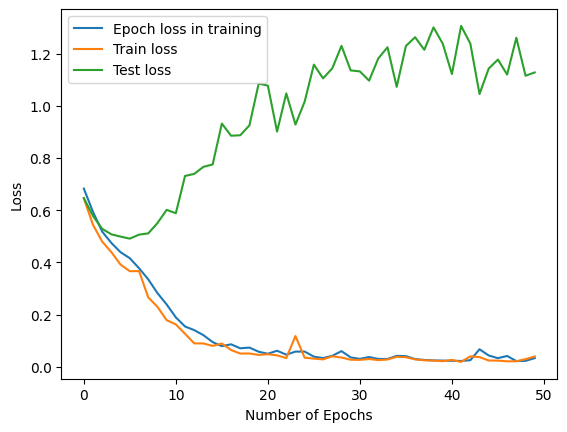

In [30]:
epochs = [i for i in range(len(epoch_loss_all))]
plt.plot(epochs, epoch_loss_all, label='Epoch loss in training')
plt.plot(epochs, train_loss_all, label='Train loss')
plt.plot(epochs, test_loss_all, label='Test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()

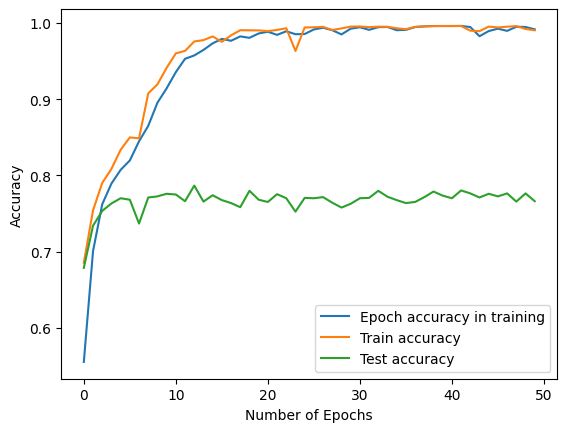

In [31]:
epochs = [i for i in range(len(epoch_acc_all))]
plt.plot(epochs, epoch_acc_all, label='Epoch accuracy in training')
plt.plot(epochs, train_acc_all, label='Train accuracy')
plt.plot(epochs, test_acc_all, label='Test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [32]:
best_model = LSTM(input_dim, hidden_dim1, hidden_dim2, output_dim)
best_model.load_state_dict(torch.load(f'{path}/final_model_lstm_word2vec.pt'))
best_model.to(device)
criterion = nn.BCEWithLogitsLoss()
accuracy = Accuracy(task="binary", threshold=0.5).to(device)
print("Train loss, Train accuracy: ", evaluate(train_loader, best_model, criterion, accuracy))
print()
print("\nTest loss, Test accuracy: ", evaluate(test_loader, best_model, criterion, accuracy))

100%|██████████| 125/125 [00:01<00:00, 79.93it/s]


Train loss, Train accuracy:  (0.09003025221079589, 0.9757500290870667)



100%|██████████| 32/32 [00:00<00:00, 56.84it/s]


Test loss, Test accuracy:  (0.7338820155709982, 0.78662109375)


In [36]:
class MovieReview(Dataset):

    def __init__(self, path, dataset_type='train', feat='w2v'):
        self.X = np.load(f'{path}/dataset_shift_X_glove_1200.npy', allow_pickle=True)
        self.y = np.load(f'{path}/dataset_shift_y_glove_1200.npy', allow_pickle=True)
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X_sample = self.X[idx]
        y_sample = self.y[idx]
        return (X_sample, y_sample)

In [37]:
path = '/content/drive/Shareddrives/CIS 519 Project/subset_data'

shift_dataset = MovieReview(path=path, dataset_type='train', feat='glove')

In [38]:
shift_loader = DataLoader(shift_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [40]:
for X, y in shift_loader:
    print(X.shape, y.shape)
    break

torch.Size([64, 300]) torch.Size([64])


In [39]:
print("Shift loss, Shift accuracy: ", evaluate(shift_loader, best_model, criterion, accuracy))

  0%|          | 0/19 [00:00<?, ?it/s]


IndexError: ignored